## Example 3: Hierarchical model

Import libraries

In [1]:
from glob import glob

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)
plt.rcParams['figure.dpi'] = 300
pd.options.mode.chained_assignment = None

Read the data.

In [3]:
DL_PATH = "data/facial_feedback/*csv"

dfs = []
columns = [
    "subject",
    "cond_id",
    "condition",
    "correct_c1",
    "correct_c2",
    "correct_c3",
    "correct_c4",
    "correct_total",
    "rating_t1",
    "rating_t2",
    "rating_c1",
    "rating_c2",
    "rating_c3",
    "rating_c4",
    "self_perf",
    "comprehension",
    "awareness",
    "transcript",
    "age",
    "gender",
    "student",
    "occupation",
]

count = 0
for idx, study in enumerate(glob(DL_PATH)):
    data = pd.read_csv(
        study, encoding="latin1", skiprows=2, header=None, index_col=False
    ).iloc[:, :22]
    data.columns = columns
    # Add study name
    data["study"] = idx
    # Some sites used the same subject id numbering schemes, so prepend with study to create unique ids.
    # Note that if we don't do this, Bambi would have no way of distinguishing two subjects who share
    # the same id, which would hose our results.
    data["uid"] = data["subject"].astype(float) + count
    dfs.append(data)
data = pd.concat(dfs, axis=0).apply(pd.to_numeric, errors="coerce", axis=1)

Reshape data

In [4]:
# Keep only subjects who (i) respond appropriately on all trials,
# (ii) understand the cartoons, and (iii) don't report any awareness
# of the hypothesis or underlying theory.
valid = data.query("correct_total==4 and comprehension==1 and awareness==0")
long = pd.melt(
    valid,
    ["uid", "condition", "gender", "age", "study", "self_perf"],
    ["rating_c1", "rating_c2", "rating_c3", "rating_c4"],
    var_name="stimulus",
)

Fit the model

In [5]:
# Initialize the model, passing in the dataset we want to use.
model = bmb.Model(
    "value ~ condition + age + gender + (1|uid) + (condition|study + stimulus)",
    long, 
    dropna=True
)

# Set a custom prior on common predictors
common_prior = bmb.Prior("Normal", mu=0, sigma=0.5)
model.set_priors(common=common_prior)

# Set a custom prior on group specific factor variances
group_specific_sd = bmb.Prior("HalfNormal", sigma=1)
group_specific_prior = bmb.Prior("Normal", mu=0, sigma=group_specific_sd)
model.set_priors(group_specific=group_specific_prior)

# Set a custom prior on Intercept and age
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=3),
    "age": bmb.Prior("Normal", mu=0, sigma=0.3)
}
model.set_priors(priors=priors)

# Increase taget_accept to 0.95.
idata = model.fit(target_accept=0.95, random_seed=1234)

Automatically removing 33/6940 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [value_sigma, condition|stimulus_offset, condition|stimulus_sigma, condition|study_offset, condition|study_sigma, 1|stimulus_offset, 1|stimulus_sigma, 1|study_offset, 1|study_sigma, 1|uid_offset, 1|uid_sigma, gender, age, condition, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 591 seconds.


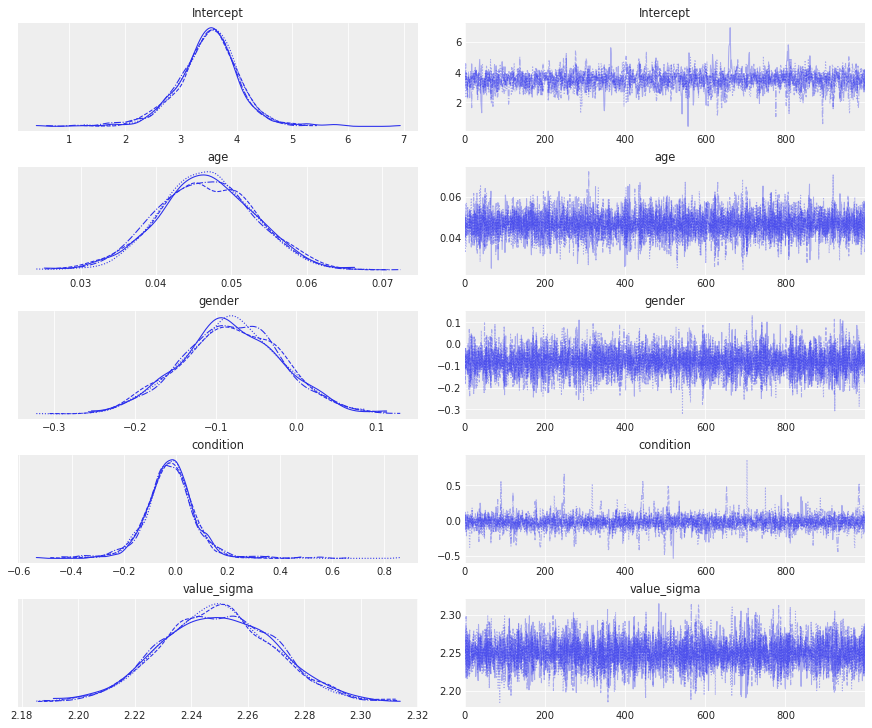

In [6]:
az.plot_trace(idata, var_names=["Intercept", "age", "gender", "condition", "value_sigma"])
plt.savefig("imgs/rrr_posterior_common.pdf")

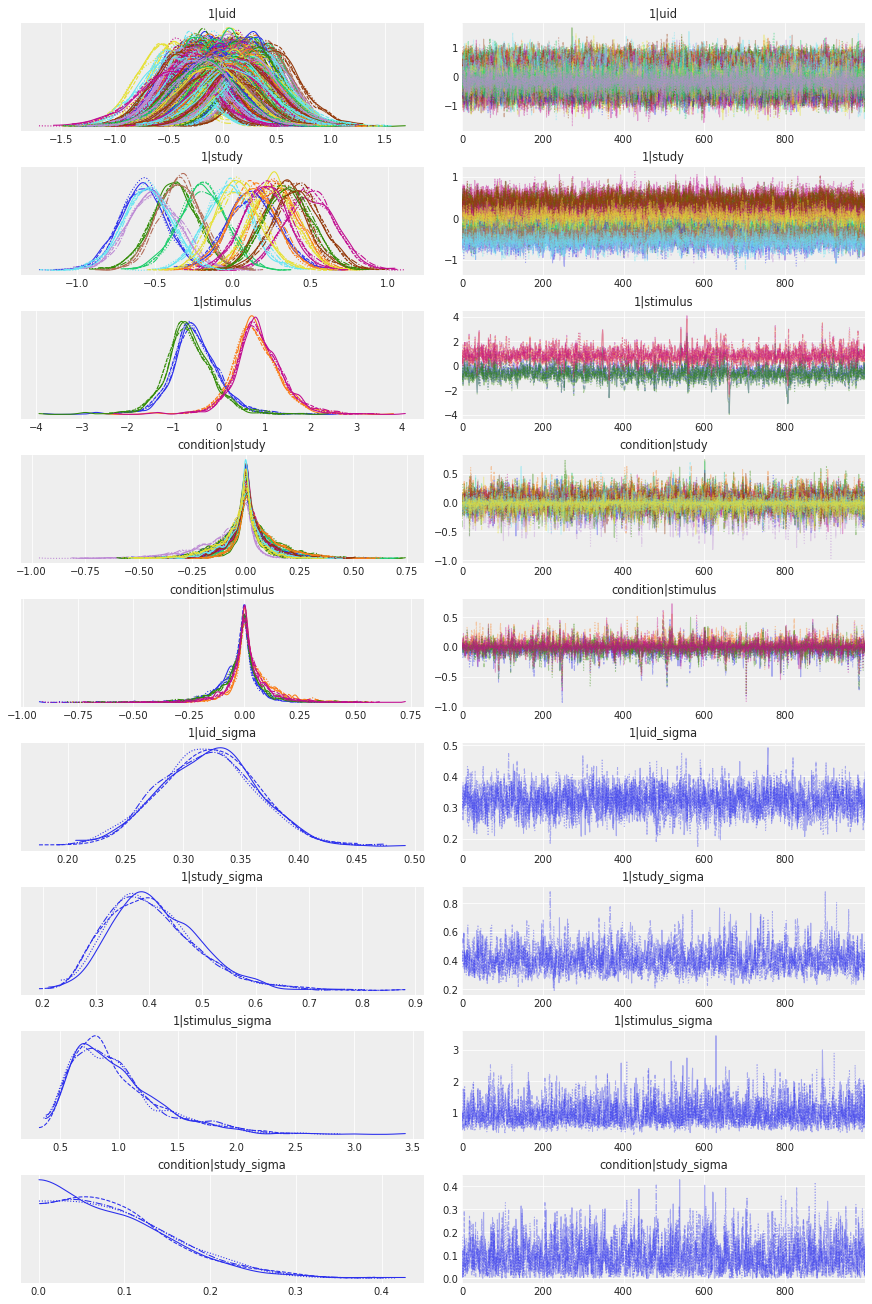

In [7]:
az.plot_trace(
    idata, 
    var_names=[
        "1|uid",
        "1|study", 
        "1|stimulus", 
        "condition|study",
        "condition|stimulus",
        "1|uid_sigma",
        "1|study_sigma",
        "1|stimulus_sigma",
        "condition|study_sigma"
    ]
)
plt.savefig("imgs/rrr_posterior_group_specific.pdf")

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -p formulae

Last updated: Thu May 19 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

formulae: 0.3.4

bambi     : 0.8.0
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
numpy     : 1.21.6
pandas    : 1.4.2
arviz     : 0.12.0
matplotlib: 3.5.2

Watermark: 2.3.0

